Block size = 1 x 1  ->  Time taken = 0.074556 sec
Block size = 2 x 2  ->  Time taken = 0.000361 sec
Block size = 4 x 4  ->  Time taken = 0.000106 sec
Block size = 8 x 8  ->  Time taken = 0.000084 sec
Block size = 12 x 12  ->  Time taken = 0.000090 sec
Block size = 16 x 16  ->  Time taken = 0.000098 sec
Block size = 20 x 20  ->  Time taken = 0.000082 sec
Block size = 24 x 24  ->  Time taken = 0.000076 sec
Block size = 28 x 28  ->  Time taken = 0.000073 sec
Block size = 32 x 32  ->  Time taken = 0.000069 sec


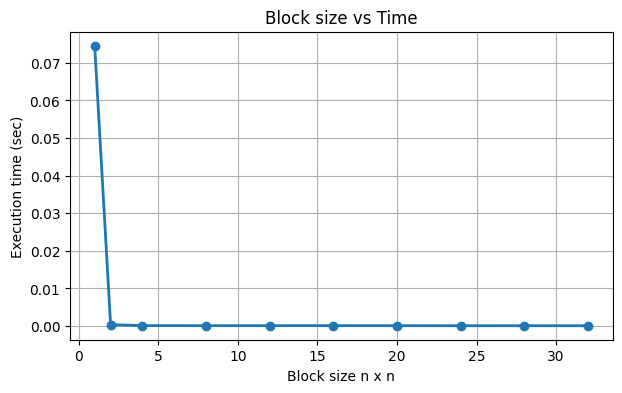

In [13]:
#### GPU Blocks & Graph ####

from PIL import Image
import time
import numpy as np
from numba import cuda, config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

# Function to convert in a grey image
@cuda.jit   # For GPU
def greyscale_gpu(src, dst):
    tidx1, tidx2 = cuda.grid(2)
    if tidx1 < src.shape[0] and tidx2 < src.shape[1]: # Image limit
        r = src[tidx1, tidx2, 0]
        g = src[tidx1, tidx2, 1]
        b = src[tidx1, tidx2, 2]
        gy = np.uint8((r + g + b) / 3)  # Average of pixels
        dst[tidx1, tidx2] = gy # The 3 pixels become grey

img = Image.open("/content/image.PNG").convert("RGB") # Load image
rgb_array = np.array(img, dtype=np.uint8)
h, w, c = rgb_array.shape
pixelCount = h * w
flat_img = rgb_array.reshape(pixelCount, 3) # 1D array

dst = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8) # Allow memory
block_sizes = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32] # Different block size values
times = [] # Timer

d_src = cuda.to_device(rgb_array)   # Input
d_dst = cuda.device_array_like(dst)  # Output

# The Loop
for threads_per_block in block_sizes:

    blocks_x = int(np.ceil(rgb_array.shape[0] / threads_per_block))
    blocks_y = int(np.ceil(rgb_array.shape[1] / threads_per_block))

    start_time = time.time() # Timer
    greyscale_gpu[(blocks_x, blocks_y), (threads_per_block, threads_per_block)](d_src, d_dst) # Function for greyscaling
    end_time = time.time()

    d_dst.copy_to_host(dst)

    time_ = end_time - start_time # Timer
    times.append(time_)
    print(f"Block size = {threads_per_block} x {threads_per_block}  ->  Time taken = {time_:.6f} sec")

# Graph
plt.figure(figsize=(7,4))
plt.plot(block_sizes, times, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Block size n x n')
plt.ylabel('Execution time (sec)')
plt.title('Block size vs Time')
plt.grid(True)
plt.show()